# Solving an eigenvalue problem with FEniCS and SLEPc

We consider here a simple, yet interesting, model problem to illustrate how to solve the eigenvalue problem within our finite element framework

We consider the problem of finding the vibration modes of a rectangular membrane clamped on the boundary. 

We denote by $u$ the scalar transverse displacement field of the membrane. 

Neglecting the bending stiffness the equation defining the dynamics of the  membrane are 

$$
\tilde E h\,\Delta u = - \rho h \dfrac{\partial^2 u }{\partial t^2} \;in\; \Omega, \quad u=0\; on \; \partial \Omega
$$
where $\rho$  is the  mass density per unit volume, $h$ is the thickness, and  $\tilde E=\frac{E}{1-nu^2}$ is the plane-stress Young modulus

Looking for solutions  of the harmonic type in time,   $u(x,t)=u(x)\,sin(\omega t)$, one find the eigenvalue problem:

$$
\text{Find } \lambda\in I\!\!R,\;u\in\mathcal{C}_0: \Delta u = \lambda \,\dfrac{\partial^2 u }{\partial t^2},\qquad \lambda =\frac{\rho\omega^2}{E}
$$
where $\mathcal C_0=\{u:\; u = 0\; \text{on} \;\partial \Omega\}$.

The corresponding weak variational formulation is :
$$
\text{Find } \lambda\in I\!\!R,\;u\in\mathcal{C}_0: a_k(u,v)-\lambda a_m(u,v)=0,\qquad \forall v\in\mathcal{C}_0
$$
where 
$$
a_k(u,v) = \int_\Omega \nabla u \cdot \nabla v\,\mathrm{d}x,\quad a_m(u,v) = \int_\Omega u\,  v\,\mathrm{d}x
$$
are the bilinear form associated to the *stiffness* and *mass* of the problem, respectively.

We will solve this problem using
 - `FEniCS` for the finite element discretisation
 - `SLEPc` as eigenvalue solver
 
 We will consider case where $\Omega $ is a unit square

Let us first define the mesh, the function space and the boundary conditions, as usual. 

Note that here the field is a scalar. We use 'FunctionSpace' instead of `VectorFunctionSpace` to get the discrete space for a scalar field.
We start with a very coarse mesh (`n=4`)

## Problem setting

In [2]:
import dolfin
import ufl
import numpy as np
import matplotlib.pyplot as plt
dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

n = 10
mesh = dolfin.UnitSquareMesh(n,n)
V = dolfin.FunctionSpace(mesh,'CG',1)
u = dolfin.Function(V)
ut = dolfin.TestFunction(V)
v = dolfin.TrialFunction(V)
dx = dolfin.Measure("dx",domain=mesh)
bc = dolfin.DirichletBC(V,0,"on_boundary") 

Let us now define the bilinear form associate to stiffness (`a_k`) and mass (`a_m`)

In [2]:
a_k = ufl.dot(ufl.grad(ut),ufl.grad(v))*dx
a_m = ut*v*dx

In the finite element discretisation, they are represented  by two matrices that we can assemble as usual

In [3]:
K = dolfin.assemble(a_k)
M = dolfin.assemble(a_m)

Let us print them on screen (possible only for small problems)

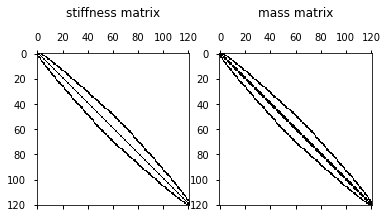

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2,)
ax = axs[0]
#ax.spy(dolfin.PETScMatrix(K_reduced).array())
ax.spy(K.array())
ax.set_title('stiffness matrix', y=1.2)
ax = axs[1]
ax.spy(M.array())
ax.set_title('mass matrix',y=1.2);

Unfortunately the generalized discrete eigenvalue problem
$$
(K-\lambda M)\, z = 0
$$
where `z = u.vector()` is not the exact problem we want to solve!

It does not account for the **boundary conditions**, i.e. the fact that membrane is clamped in our case.


## Dealing with BCs: Extracting reduced matrix with free dofs

An efficient way to avoid issues with the boundary conditions is to solve a reduced problem with modified matrices obtained by elminating rows and columns corresponding to bcs. 

The main steps are as follows:

1. Extract reduced matrix deleting rows and columns associated to bcs

2. Solve the eigenvalue problem on the reduced matrices. 

3. Add back to the eigenvectors of the reduced problem the delected dofs (with 0 values)

To this end we need to play a bit with the linear algebra backend `PETSC`. We import its python wrapper, `petsc4py`.

In [5]:
import petsc4py
from petsc4py import PETSc

We cast the matrices to petsc object to play with them directly with the `petsc4py` interface.

In [6]:
K_petsc = dolfin.as_backend_type(K).mat()
M_petsc = dolfin.as_backend_type(M).mat()
print("The type of the K_petsc matrix is ",type(K_petsc))
print("The size of the K_petsc matrix is {:}".format(K_petsc.size))


The type of the K_petsc matrix is  <class 'petsc4py.PETSc.Mat'>
The size of the K_petsc matrix is (121, 121)


With the utility function below we obtain the index set of the dof map corresponding to non blocked dofs (you can skip the details). 

In [7]:
def get_interior_index_set(boundary_conditions, function_space):
    """Returns the index set with free dofs"""
    # Find dofs affected by the boundary conditions
    bc_dofs = [] 
    try:
        for bc in boundary_conditions:
            bc_dofs.extend(bc.get_boundary_values().keys()) 
    except:
        bc_dofs.extend(boundary_conditions.get_boundary_values().keys()) 
        
    ownership_range = function_space.dofmap().ownership_range()
    interior_dofs = [x for x in range(ownership_range[0], ownership_range[1]) if x not in bc_dofs]    
    # Create petsc4py.PETSc.IS object with interior degrees of freedom
    index_set = petsc4py.PETSc.IS()
    index_set.createGeneral(interior_dofs)  
    return index_set

index_set_not_bc = get_interior_index_set(bc, V)
index_set_not_bc.array

array([  4,   7,   8,  11,  12,  13,  16,  17,  18,  19,  22,  23,  24,
        25,  26,  29,  30,  31,  32,  33,  34,  37,  38,  39,  40,  41,
        42,  43,  46,  47,  48,  49,  50,  51,  52,  53,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  67,  68,  69,  70,  71,  72,  73,
        74,  77,  78,  79,  80,  81,  82,  83,  86,  87,  88,  89,  90,
        91,  94,  95,  96,  97,  98, 101, 102, 103, 104, 107, 108, 109,
       112, 113, 116], dtype=int32)

With this information we can extract the relevant submatrices for the eigenvalue problem.

In [8]:
K_reduced = K_petsc.createSubMatrix(index_set_not_bc, index_set_not_bc)
M_reduced = M_petsc.createSubMatrix(index_set_not_bc, index_set_not_bc)
print("Size of the reduced matrix is {0:}.".format(K_reduced.size))

Size of the reduced matrix is (81, 81).


## SLEPc eigenvalue solver

We have now the following *generalized hermitian (symmetric) eigenvalue problem` to solve
$$
(K_\mathrm{reduced}-\lambda\, M_\mathrm{reduced})y=0
$$

We will use here the tools for solving large sparse eigenvalue problems provided by  PETSc and SLEPc.

In particular we will use the `slepc4py` module providing a python interface to `SLEPc` (and `petsc4py` for `PETSc`).

We suggest the have a look to the following tutorial for `slepc4py` 

- `slepc4py` tutorial: https://slepc4py.readthedocs.io/en/stable/tutorial.html

and to refer to the following complete documentation for any further details on the available algorithm in SLEPc and the eigenvalue solvers.

- `SLEPc`manual: http://slepc.upv.es/documentation/current/docs/slepc.pdf

We need to import the new modules

In [9]:
from petsc4py import PETSc
from slepc4py import SLEPc

Let us first initialize the eigenvalue solver object from `SLEPc` and set into the solver object the two operators (matrices) that define the generilised eigenvalue problem.

In [10]:
E = SLEPc.EPS()
E.create()
E.setOperators(K_reduced,M_reduced)

We can now solve the problem, after specifing how many eigenvalues and eigenvectors we wish to compute.
We define some options that serve to select an appropiate solver. 
In particular, we use a `krylovschur`  method with `shift and invert` with `0` as target eigenvalue (see `SLEPc` manual).
After the solve, we retrieve some informations on how many eigenvalues have been succefully computed, tollerances, and so on.


In [11]:
n_eig = 10 
dolfin.set_log_level(10)
#opts = PETSc.Options()
E.setDimensions(n_eig)
E.setType(SLEPc.EPS.Type.KRYLOVSCHUR)
E.setProblemType(SLEPc.EPS.ProblemType.GHEP)
#E.setWhichEigenpairs(E.Which.SMALLEST_MAGNITUDE)
#eps.setFromOptions()
E.setWhichEigenpairs(E.Which.TARGET_MAGNITUDE)
E.setTarget(0) 
st = E.getST()
st.setType('sinvert')
E.solve()

# get the stats about the solve
its = E.getIterationNumber()
print("Number of iterations of the method: {:d}".format(its))
eps_type = E.getType()
print("Solution method: {:s}".format(eps_type))
nev, ncv, mpd = E.getDimensions()
print("Number of requested eigenvalues: {:d}".format(nev))
tol, maxit = E.getTolerances()
print("Stopping condition: tol={:.4g}, maxit={:d}".format(tol, maxit))
nconv = E.getConverged()
print("Number of converged eigenpairs {:d}".format(nconv))

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 10
Stopping condition: tol=1e-08, maxit=100
Number of converged eigenpairs 11


Once the problem is solved we can finally ask for the solution, i.e. the values of the eigenvalues and the eigenvectors that have been computed.

Let us do it for a single eigenpair, the first.

We  initialize the two fields on our finite element function space, `u_r` and `u_i`, as vector with teh same dimension of the matrix, where we will store the real and imaginary part of the eigenvector (we need to define the immaginary part even if we can anticipate that it should be zero for our symmetric real generalized eigenvalue problem)

In [12]:
# extract the eigenpair i
i = 0
u_reduced_r, u_reduced_i = K_reduced.createVecs()
eig = E.getEigenpair(i, u_reduced_r, u_reduced_i)
print("Eigenvalue with real part {:4.3f} and imaginary part {:4.3f}".format(eig.real,eig.imag))

Eigenvalue with real part 20.228 and imaginary part 0.000


We need now to project back the eigenvector to the full function space adding back the dofs corresponding to bcs. 
To perform this mapping we create a petsc scatter. 

In [13]:
projector = petsc4py.PETSc.Scatter()
projector.create(
    vec_from=u_reduced_r,
    is_from=None,
    vec_to=dolfin.Function(V).vector().vec(),
    is_to=index_set_not_bc
    )

And we use it to have the full eigenvector including blocked dofs, that we can use in dolfin, and plot.
We do it only for the real part, the imaginary part being null here.

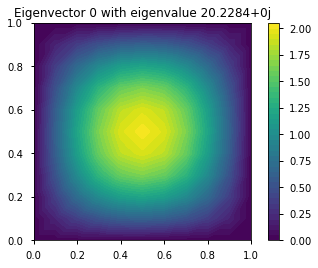

In [14]:
u_r = dolfin.Function(V)
projector.scatter(vec_from=u_reduced_r, vec_to=u_r.vector().vec())
plt.colorbar(dolfin.plot(u_r,title="Eigenvector {:d} with eigenvalue {:6g}".format(i,eig)))

Let us now extract all the eigenpairs, store them in a list, and plot them.


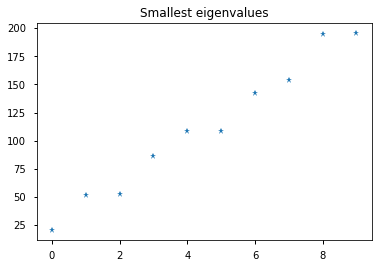

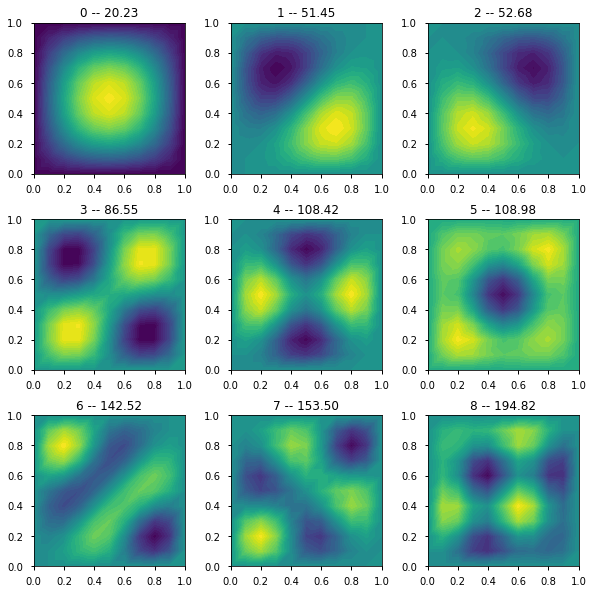

In [15]:
eigenvalues = []
eigenvectors = []

for i in range(n_eig):
    u_r = dolfin.Function(V)
    eig = E.getEigenpair(i,  u_reduced_r, u_reduced_i)
    eigenvalues.append(eig.real)
    projector.scatter(vec_from=u_reduced_r, vec_to=u_r.vector().vec())
    eigenvectors.append(u_r)
    
# plot the eigenvalues
plt.plot(eigenvalues,"*")
plt.title("Smallest eigenvalues")

# plot the eigenvectors
figure = plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    dolfin.plot(eigenvectors[i])
    plt.title("{:d} -- {:2.2f}".format(i,eigenvalues[i].real))
plt.gcf().subplots_adjust(hspace = .3)

# Wrap up: refactoring

We refactor the code above in a class `EigenSolver` that we can reuse as a module in the rest of the course. 

The code is included in the module `slepc_eigensolver.py` 

We give below an example on its use.

---- setting additional slepc options -----
     eps_max_it : 100
-------------------------------------------
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 3 iterations  : 13/10


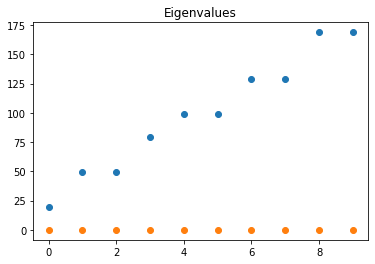

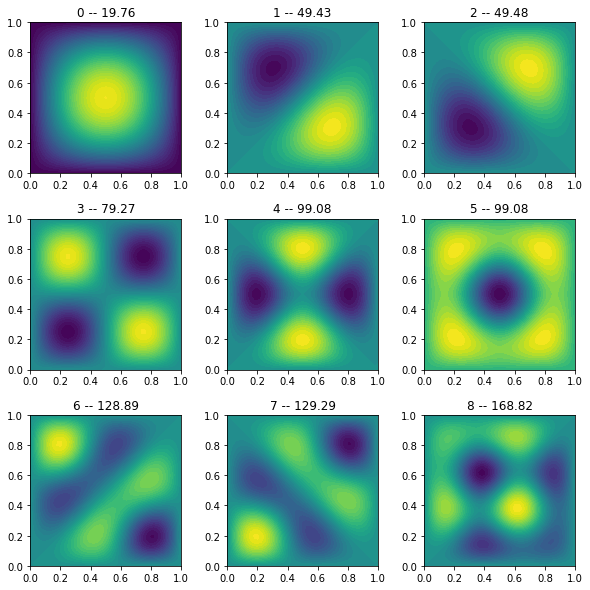

In [4]:
import dolfin
import ufl
import numpy as np
import matplotlib.pyplot as plt
from slepc_eigensolver import EigenSolver

# define the variational problem
mesh = dolfin.UnitSquareMesh(50,50)
V = dolfin.FunctionSpace(mesh,'CG',1)
u = dolfin.Function(V)
ut = dolfin.TestFunction(V)
v = dolfin.TrialFunction(V)
bc = dolfin.DirichletBC(V,0,"on_boundary") 
a_k = ufl.dot(ufl.grad(ut),ufl.grad(v))*dolfin.dx
a_m = ut*v*dolfin.dx

# solving the eigenproblem
eig_solver = EigenSolver(a_k, a_m, u, bcs=bc)
ncv, it = eig_solver.solve(10)
eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(10)
eig_solver.save_eigenvectors(ncv)

# plots
plt.figure()
plt.plot(eigenvalues.real,'o')
plt.plot(eigenvalues.imag,'o')
plt.title("Eigenvalues")

figure = plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    dolfin.plot(eigenvectors_real[i])
    plt.title("{:d} -- {:2.2f}".format(i,eigenvalues[i].real))
plt.gcf().subplots_adjust(hspace = .3)
